# CS684 Final Project: Skin Cancer Classification  
Authors: 
* Henry Pabst
* Antony Albert Raj
* Brian Cechmanek

### Project description:  
Detection and Classification: Choose one computer vision competition on Kaggle.com from the list below and apply any algorithm you've learnt in class or any computer vision algorithm of your choice. Your approach should be clearly motivated. Use critical thinking and build an intuition about what works and what doesn't. Describe your idea in the report, do two 2 iterations on that idea. What worked, what didn't work, and what you would do given more resources/time. 
* https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

## Executive Summary

We trained VGG16, ResNet50, and a custom architecture (CA) for classification of the lesion types as well as for bounding-box localization of the lesions for each image. Top classification accuracies for VGG16, ResNet50, and the CA were 73.28%, 81.40%, and 73.78%, respectively. Top localization for VGG16, ResNet50, and the CA were 79.00%, 82.02%, and 80.52%, respectively.

Future work would explore usage of the additional data provided: age, sex, and (bodily) localization of the lesions. Additional preliminary feature extraction may be useful as well. Additional resources were not a limiting factor in this project: a notebook gpu (nvidia 1060) was able to train the VGG16 localization model in fewer than 15 minutes. Further, investigation into the features learned by each network may be beneficial in tailouring a more task-specific classifier. 

## Code

All code for this project are contained within the `src` directory as `.py` files. Training and testing of the models in controlled by the `main.py` file, where the specific model is be selected by modifying the `main` function, and then runinng via the commandline.

## Results

This notebook walks through the stages of this project, reporting on the results we gathered. This notebook provides runable cells for recreating the models we developed, allowing for some hyperparameter tweaks, and do not necessarily show the top models we trained (see `Code`, above).

The notebook is organized into:  
1. Loading the dataset  
2. Data cleaning and pre-processing  
3. Data profiling (to gain early insights)  
4. Deep Learning Architectures  
    4a. VGG16  
    4b. ResNet50  
    4c. Custom Architecture (and motivation)  
5. Conclusion

___________________

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('..', 'data')


import image_augmentation
import utils
import nn_models
import main as mn

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


..\saved_models


### Load data 

In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, 'images', '*.jpg'))}

In [3]:
imageid_path_dict

{'ISIC_0024306': '..\\data\\images\\ISIC_0024306.jpg',
 'ISIC_0024307': '..\\data\\images\\ISIC_0024307.jpg',
 'ISIC_0024308': '..\\data\\images\\ISIC_0024308.jpg',
 'ISIC_0024309': '..\\data\\images\\ISIC_0024309.jpg',
 'ISIC_0024310': '..\\data\\images\\ISIC_0024310.jpg',
 'ISIC_0024311': '..\\data\\images\\ISIC_0024311.jpg',
 'ISIC_0024312': '..\\data\\images\\ISIC_0024312.jpg',
 'ISIC_0024313': '..\\data\\images\\ISIC_0024313.jpg',
 'ISIC_0024314': '..\\data\\images\\ISIC_0024314.jpg',
 'ISIC_0024315': '..\\data\\images\\ISIC_0024315.jpg',
 'ISIC_0024316': '..\\data\\images\\ISIC_0024316.jpg',
 'ISIC_0024317': '..\\data\\images\\ISIC_0024317.jpg',
 'ISIC_0024318': '..\\data\\images\\ISIC_0024318.jpg',
 'ISIC_0024319': '..\\data\\images\\ISIC_0024319.jpg',
 'ISIC_0024320': '..\\data\\images\\ISIC_0024320.jpg',
 'ISIC_0024321': '..\\data\\images\\ISIC_0024321.jpg',
 'ISIC_0024322': '..\\data\\images\\ISIC_0024322.jpg',
 'ISIC_0024323': '..\\data\\images\\ISIC_0024323.jpg',
 'ISIC_002

In [4]:
hmnist_28_rgb_df = pd.read_csv(os.path.join(base_skin_dir, 'hmnist_28_28_RGB.csv'))
hmnist_28_rgb_df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...    pixel2343  pixel2344  \
0        197        154        185        202  ...          173        124   
1        123         93        126        158  ...           60         39   
2        201        142        160        206  ...          167        129   
3        143        103        119        171  ...           44         26   
4        215        162        191        225  ...          209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [5]:
# shown for completeness - not used in project (and are just transformations of RGB anyways, so a network should learn
# weights from them essentially the same anyway).
hmnist_28_l_df = pd.read_csv(os.path.join(base_skin_dir, 'hmnist_28_28_L.csv'))
hmnist_28_l_df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        169        171        170        177        181        182   
1         19         57        105        140        149        148   
2        155        163        161        167        167        172   
3         25         71        116        139        136        153   
4        129        162        181        196        205        208   

   pixel0006  pixel0007  pixel0008  pixel0009  ...    pixel0775  pixel0776  \
0        181        185        194        192  ...          184        186   
1        144        155        170        170  ...          172        175   
2        155        152        165        175  ...          163        178   
3        148        161        172        162  ...          125        135   
4        205        213        225        224  ...          210        197   

   pixel0777  pixel0778  pixel0779  pixel0780  pixel0781  pixel0782  \
0        185        180        157        140        140        159   
1        160        144        114         89         47         18   
2        157        166        167        148        141        136   
3        138        137        111         71         32         16   
4        172        190        195        193        181        147   

   pixel0783  label  
0        165      2  
1         18      2  
2        115      2  
3         16      2  
4         88      2  

[5 rows x 785 columns]

In [6]:
ham10000_meta_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
ham10000_meta_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [8]:
ham10000_meta_df['path'] = ham10000_meta_df['image_id'].map(imageid_path_dict.get)
ham10000_meta_df['cell_type'] = ham10000_meta_df['dx'].map(lesion_type_dict.get) 
ham10000_meta_df['cell_type_idx'] = pd.Categorical(ham10000_meta_df['cell_type']).codes
ham10000_meta_df.sample(3)

lesion_id      image_id  dx    dx_type   age     sex     localization  \
3626  HAM_0003060  ISIC_0027485  nv  follow_up  40.0    male          abdomen   
3449  HAM_0000652  ISIC_0028597  nv  follow_up  40.0  female  upper extremity   
5000  HAM_0004631  ISIC_0032473  nv  follow_up  55.0  female            trunk   

                                 path         cell_type  cell_type_idx  
3626  ..\data\images\ISIC_0027485.jpg  Melanocytic nevi              4  
3449  ..\data\images\ISIC_0028597.jpg  Melanocytic nevi              4  
5000  ..\data\images\ISIC_0032473.jpg  Melanocytic nevi              4

In [9]:
ham10000_meta_df.describe(exclude=[np.number])

lesion_id      image_id     dx dx_type    sex localization  \
count         10015         10015  10015   10015  10015        10015   
unique         7470         10015      7       4      3           15   
top     HAM_0005263  ISIC_0028960     nv   histo   male         back   
freq              6             1   6705    5340   5406         2192   

                                   path         cell_type  
count                             10015             10015  
unique                            10015                 7  
top     ..\data\images\ISIC_0024606.jpg  Melanocytic nevi  
freq                                  1              6705

In [10]:
# load in all of the images
ham10000_meta_df['image_id'] = ham10000_meta_df['path'].dropna().map(imread)

### Data Cleaning and preprocessing
Check the datasets for missing or data otherwise requiring preprocessing. 
We will start profiling after this step

In [11]:
# check for nans
ham10000_meta_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [12]:
print("median age: ", ham10000_meta_df['age'].mean())
print("mean age: ", ham10000_meta_df['age'].median())

median age:  51.863828077927295
mean age:  50.0


57 images are missing age information. Imputation by mean or median may be approriate in this instance. Dropping these images could also be performed, due to the size of the dataset. At this time, we choose to impute the mean age, which we believe reasonable given the continuous nature of age and the distribution in the dataset (see histogram below, in data profiling)

In [13]:
ham10000_meta_df['age'].fillna((ham10000_meta_df['age'].mean()), inplace=True)

In [14]:
hmnist_28_rgb_df.isnull().sum().any() # none, no need to print all pixel columns

False

In [15]:
hmnist_28_l_df.isnull().sum().any()   # none, no need to print all pixel columns

False

#### Labelling of Bounding-Boxes
To perform lesion localization, bounding-boxes were manually assigned for all images within the ham 10000 dataset - two students labelling 5000 images, each. Lesion boundaries were determined by visual inspection and box-corners were exported to `json` files the open-source LabelMe GUI (https://github.com/wkentaro/labelme). 

Due to time constrictions of this project, bounding-boxes were determined once for each image. Multiple validation and/or location averaging were not performed. One of the labellers has significant experience in histological annotation and so bounding boxes may be biased compared to the other labeller. When multiple lesions were present per image, the largest was selected, unless the lesions were closely packed in a 'cluster" such that a single bounding-box was deemed appropriate. 

While neither labeller had experience in labelling of oncological lesions, implicit biases may exist due to the inherent visual differences between the lesion types. 

N.B: the dataset was heavily skewed towards lesions centered in the image, and often quite large in proportion to the image itself. Care must be taken to ensure that a classifier does not simply learn to predict a large box in the center of the image.

![Bounding-Box Determination Example](../images/LabelMeExample.PNG)

## Data Profiling
look for early insights into the dataset which may guide development of the classifier:
* class imbalances
* outliers
* potential features to extract

### Summary

* Class imbalance: Melanocytic nevi is highly over-represented in the dataset (66.49%), with the next closest class, dermatofibroma around 1/6th as frequent (11.11%)

#### Lesion Class (im)Balance
Check the distribution of lesions within the full dataset

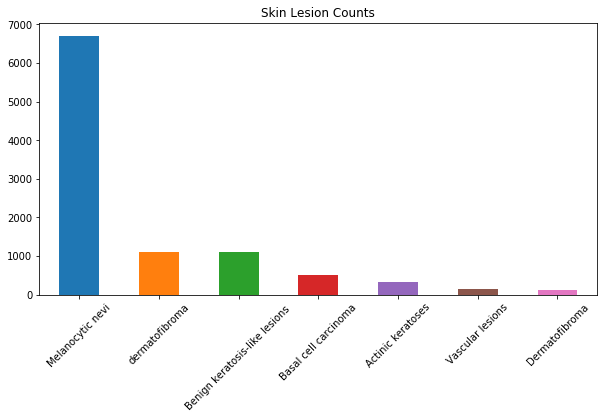

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
ham10000_meta_df['cell_type'].value_counts().plot(kind='bar', ax=ax1, title="Skin Lesion Counts", rot=45)

In [19]:
ham10000_meta_df['cell_type'].value_counts() / ham10000_meta_df['cell_type'].value_counts().sum() * 100

Melanocytic nevi                  66.949576
dermatofibroma                    11.113330
Benign keratosis-like lesions     10.973540
Basal cell carcinoma               5.132302
Actinic keratoses                  3.265102
Vascular lesions                   1.417873
Dermatofibroma                     1.148278
Name: cell_type, dtype: float64

We use a static `train_test_split` for reproducibility of results. the breakdowns of the final datasets by lesion type are:

| lesion class |                  full dataset | train_split | test_split |
| ----------------------------- | ------------ | ----------- | ---------- | 
| Melanocytic nevi              |    66.949576 |     66.9371 |    66.1008 |
| dermatofibroma                |    11.113330 |     11.2831 |    10.9835 |
| Benign keratosis-like lesions |    10.973540 |     11.0709 |    10.5841 | 
| Basal cell carcinoma          |     5.132302 |      4.9675 |     5.1922 |
| Actinic keratoses             |     3.265102 |      3.2327 |     4.5432 |
| Vascular lesions              |     1.417873 |      1.3854 |     1.4978 |     
| Dermatofibroma                |     1.148278 |      1.1233 |     1.0984 |

#### Patient Ages
Are the data skewed to any particular age range(s)? If so, it may be the case that lesions, or background skin tissue differ in some way that may be impactul to the data.

Text(0.5, 1.0, 'Age Distribution of Lesion Images')

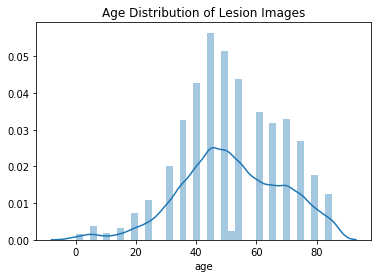

In [20]:
sns.distplot(ham10000_meta_df['age'].dropna()).set_title("Age Distribution of Lesion Images")

#### Lesion localization - bodily
How distributed are lesions across the body? 

#### Sex (im)Balances
* Overall the dataset are 53% male, 45% female, 0.5% unknown. 
* By lesion,type

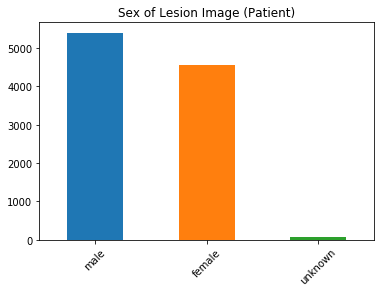

In [22]:
ham10000_meta_df['sex'].value_counts().plot(kind='bar', rot=45, title="Sex of Lesion Image (Patient)")

In [23]:
ham10000_meta_df['sex'].value_counts() / ham10000_meta_df['sex'].value_counts().sum() *100

male       53.979031
female     45.451822
unknown     0.569146
Name: sex, dtype: float64

In [24]:
sex_balance_counts = {}
for lesion_type in lession_type_dict:
    sex_balance_counts[lesion_type] = ham10000_meta_df[ham10000_meta_df['dx']==lesion_type]['sex'].value_counts()
sex_balance_counts

{'nv': male       3421
 female     3237
 unknown      47
 Name: sex, dtype: int64, 'mel': male      689
 female    424
 Name: sex, dtype: int64, 'bkl': male       626
 female     463
 unknown     10
 Name: sex, dtype: int64, 'bcc': male      317
 female    197
 Name: sex, dtype: int64, 'akiec': male      221
 female    106
 Name: sex, dtype: int64, 'vasc': female    73
 male      69
 Name: sex, dtype: int64, 'df': male      63
 female    52
 Name: sex, dtype: int64}

## Show off a few in each category

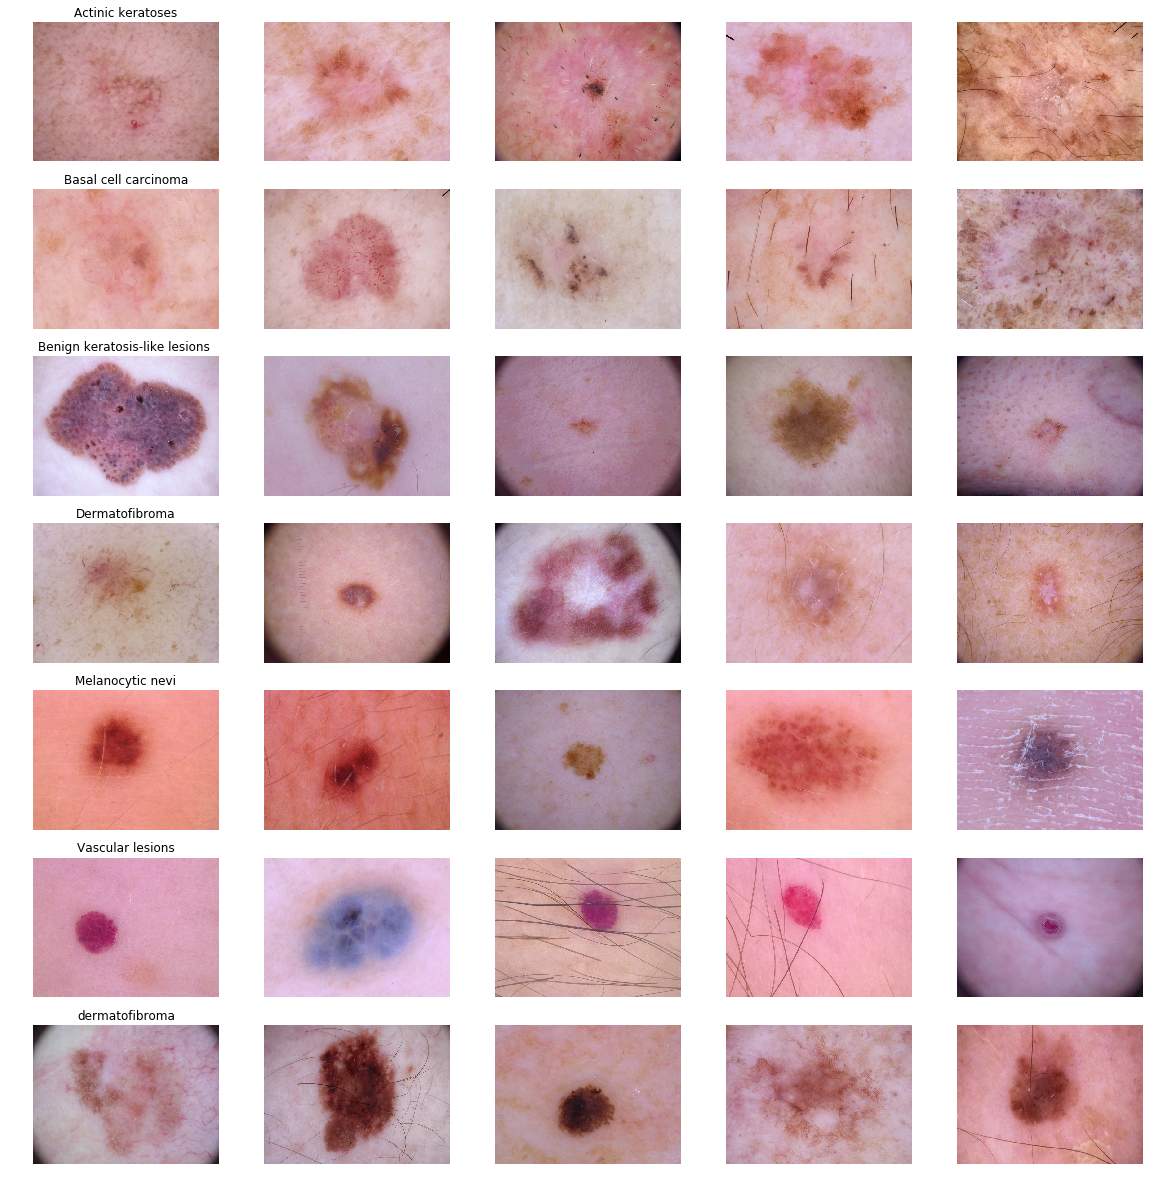

In [25]:
# code from https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         ham10000_meta_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image_id'])
        c_ax.axis('off')
#fig.savefig('category_samples.png', dpi=300)

## Get Average Color Information
Here we get and normalize all of the color channel information

In [26]:
ham10000_meta_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

In [27]:
rgb_info_df = ham10000_meta_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image_id'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(3)

Red_mean  Green_mean  Blue_mean   Gray_mean
9237  1.121977    0.938128   0.939895  175.991843
3970  1.323764    0.782285   0.893951  152.128136
7071  1.067448    0.919060   1.013492  165.083931

In [28]:
for c_col in rgb_info_df.columns:
    ham10000_meta_df[c_col] = rgb_info_df[c_col].values

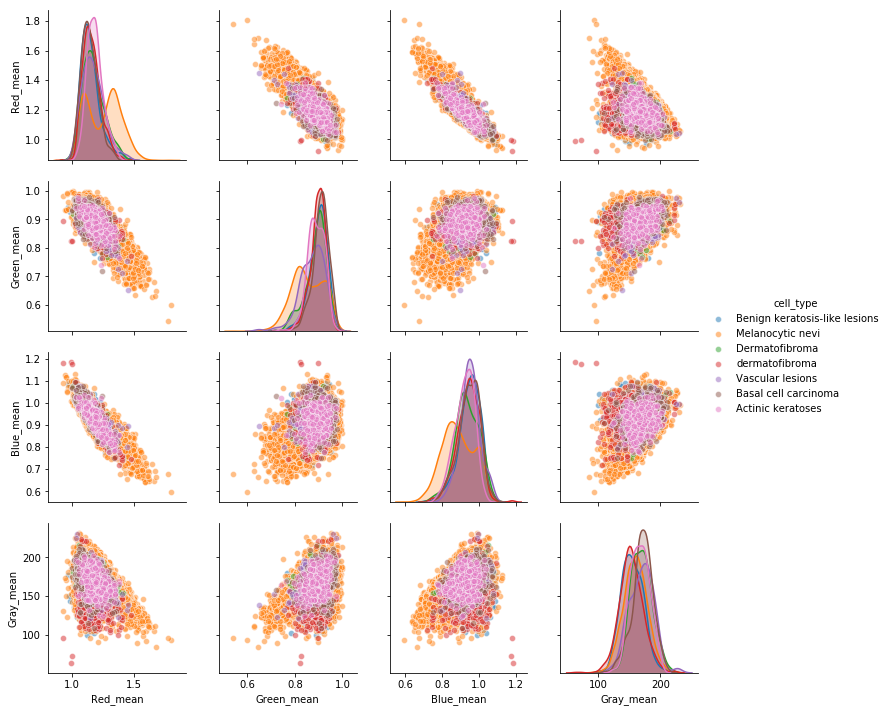

In [29]:
sns.pairplot(ham10000_meta_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

## 4. Deep Learning Architectures

### 4a. VGG16
Following class lectures, we applied the VGG16 architecture as a first benchmark in lesion classification and localization. 
While assignment_3 asked for an implementation of VGG11, we opted for the updated (and higher performing) VGG16. Keras comes with a pre-built VGG16 model, for acccessibility, but we chose to re-build the VGG11 implementation from assignment 3 into VGG16. This allowed us to add batchNormalization, for example. 

Notes: 
* We did not use any pre-trained weights for VGG16, instead opting to learn all from scratch solely on our dataset. 
* Due to memory pressures, images had to be resized in the localization models, this is not fast even on a high-end laptop

In [8]:
#bias the loss on the sample_weights of inputs (b/c data are so imablanced)
from sklearn.utils.class_weight import compute_class_weight

(x_train, y_train), (x_test, y_test) = utils.read_skin_cancer_data(test_split=0.2, seed=None, resize_data=None)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights
del x_train, y_train

# ultimately, this does not solve the issue for this model, but we include the runable example should
# it wish to be explored with and without.

Reading skin cancer data...
Creating support objects...
Augmenting dataset...
Creating VGG16 model...
Epoch 1/100
7/6 [=================================] - 16s 2s/step - loss: 88.4832 - acc: 0.5839 - val_loss: 85.0273 - val_acc: 0.6683

Epoch 00001: val_acc improved from -inf to 0.66828, saving model to ..\saved_models/vgg16_valacc0.6683-epoch01.h5
Epoch 2/100
7/6 [=================================] - 3s 500ms/step - loss: 82.4437 - acc: 0.6752 - val_loss: 78.9817 - val_acc: 0.6683

Epoch 00002: val_acc did not improve from 0.66828
Epoch 3/100
7/6 [=================================] - 3s 471ms/step - loss: 76.5108 - acc: 0.6780 - val_loss: 73.2253 - val_acc: 0.6683

Epoch 00003: val_acc did not improve from 0.66828
Epoch 4/100
7/6 [=================================] - 3s 470ms/step - loss: 70.8754 - acc: 0.6752 - val_loss: 67.8081 - val_acc: 0.6683

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00004: val_acc did not improve from 0.66828
Epoch 5

7/6 [=================================] - 3s 483ms/step - loss: 53.0490 - acc: 0.6667 - val_loss: 53.0297 - val_acc: 0.6683

Epoch 00041: val_acc did not improve from 0.66828
Epoch 42/100
7/6 [=================================] - 3s 485ms/step - loss: 52.9435 - acc: 0.6892 - val_loss: 52.9874 - val_acc: 0.6683

Epoch 00042: val_acc did not improve from 0.66828
Epoch 43/100
7/6 [=================================] - 5s 783ms/step - loss: 52.9430 - acc: 0.6780 - val_loss: 52.9450 - val_acc: 0.6683

Epoch 00043: val_acc did not improve from 0.66828
Epoch 44/100
7/6 [=================================] - 3s 490ms/step - loss: 52.8528 - acc: 0.6949 - val_loss: 52.9027 - val_acc: 0.6683

Epoch 00044: val_acc did not improve from 0.66828
Epoch 45/100
7/6 [=================================] - 3s 491ms/step - loss: 52.8802 - acc: 0.6639 - val_loss: 52.8599 - val_acc: 0.6683

Epoch 00045: val_acc did not improve from 0.66828
Epoch 46/100
7/6 [=================================] - 3s 487ms/step - lo


Epoch 00084: val_acc did not improve from 0.66828
Epoch 85/100
7/6 [=================================] - 3s 484ms/step - loss: 51.1502 - acc: 0.6836 - val_loss: 51.1762 - val_acc: 0.6683

Epoch 00085: val_acc did not improve from 0.66828
Epoch 86/100
7/6 [=================================] - 5s 776ms/step - loss: 51.1035 - acc: 0.6864 - val_loss: 51.1348 - val_acc: 0.6683

Epoch 00086: val_acc did not improve from 0.66828
Epoch 87/100
7/6 [=================================] - 3s 486ms/step - loss: 51.0659 - acc: 0.6808 - val_loss: 51.0932 - val_acc: 0.6683

Epoch 00087: val_acc did not improve from 0.66828
Epoch 88/100
7/6 [=================================] - 5s 775ms/step - loss: 51.0684 - acc: 0.6667 - val_loss: 51.0517 - val_acc: 0.6683

Epoch 00088: val_acc did not improve from 0.66828
Epoch 89/100
7/6 [=================================] - 3s 488ms/step - loss: 50.9757 - acc: 0.6836 - val_loss: 51.0095 - val_acc: 0.6683

Epoch 00089: val_acc did not improve from 0.66828
Epoch 90/

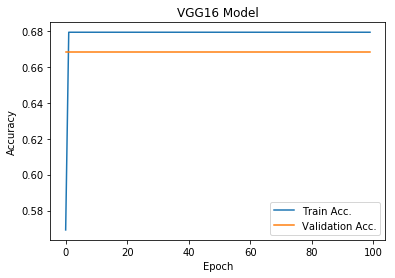

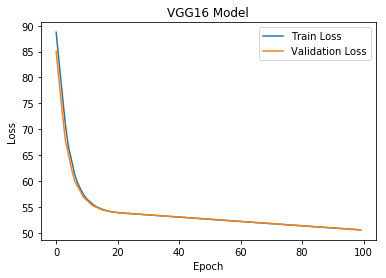

Confusion matrix, without normalization
[[   0    0    0    0   68    0    0]
 [   0    0    0    0  116    0    0]
 [   0    0    0    0  212    0    0]
 [   0    0    0    0   25    0    0]
 [   0    0    0    0 1342    0    0]
 [   0    0    0    0   31    0    0]
 [   0    0    0    0  209    0    0]]


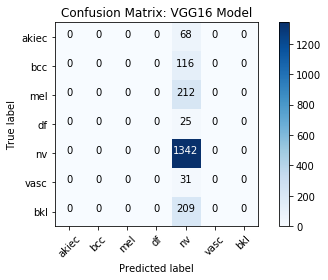

Training model...


In [9]:
vgg16_model = mn.test_vgg16_model(optimizer='adam', lr=0.0001, class_weight=d_class_weights)

Reading skin cancer data...
Creating VGG16 Localization Model...
Training model...
Train on 7209 samples, validate on 801 samples
Epoch 1/100
 - 28s - loss: 44.2730 - box_output_loss: 428.0143 - class_output_loss: 1.4716 - box_output_acc: 0.2072 - class_output_acc: 0.6288 - val_loss: 38.7057 - val_box_output_loss: 373.3578 - val_class_output_loss: 1.3700 - val_box_output_acc: 0.2672 - val_class_output_acc: 0.6792
Epoch 2/100
 - 21s - loss: 39.0273 - box_output_loss: 379.4301 - class_output_loss: 1.0843 - box_output_acc: 0.3337 - class_output_acc: 0.6583 - val_loss: 36.6904 - val_box_output_loss: 357.1151 - val_class_output_loss: 0.9788 - val_box_output_acc: 0.4270 - val_class_output_acc: 0.6779
Epoch 3/100
 - 21s - loss: 37.9763 - box_output_loss: 370.0570 - class_output_loss: 0.9706 - box_output_acc: 0.4274 - class_output_acc: 0.6685 - val_loss: 36.3377 - val_box_output_loss: 353.3735 - val_class_output_loss: 1.0004 - val_box_output_acc: 0.4607 - val_class_output_acc: 0.6442
Epoch 4/1

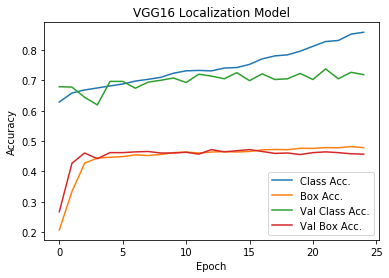

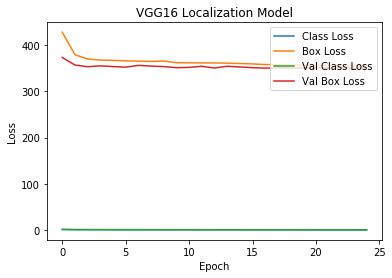

Confusion matrix, without normalization
[[  15   12   23    2    9    5    1]
 [   5   66   20    0    6   12    3]
 [   5   16   97    1   22   69    4]
 [   3   12    5    2    0    2    1]
 [   5    6   32    0   82   79    2]
 [   3   23   37    4   59 1222    3]
 [   0    2    1    0    0    8   17]]


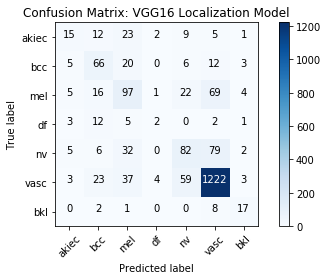

In [10]:
vgg_16_local = mn.test_vgg16_localization_model(optimizer='adam', lr=0.0001)

### 4b. ResNet50 

Reading skin cancer data...


C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Creating support objects...
Augmenting dataset...
Creating ResNet50 Model...


C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100
7/6 [=================================] - 16s 2s/step - loss: 1.9423 - acc: 0.4578 - val_loss: 1.5799 - val_acc: 0.5338

Epoch 00001: val_acc improved from -inf to 0.53377, saving model to ..\saved_models/resnet50_valacc0.5338-epoch01.h5
Epoch 2/100
7/6 [=================================] - 3s 455ms/step - loss: 1.5503 - acc: 0.6129 - val_loss: 3.4747 - val_acc: 0.6686

Epoch 00002: val_acc improved from 0.53377 to 0.66856, saving model to ..\saved_models/resnet50_valacc0.6686-epoch02.h5
Epoch 3/100
7/6 [=================================] - 3s 449ms/step - loss: 1.3505 - acc: 0.6474 - val_loss: 3.7340 - val_acc: 0.6509

Epoch 00003: val_acc did not improve from 0.66856
Epoch 4/100
7/6 [=================================] - 3s 449ms/step - loss: 1.1171 - acc: 0.6508 - val_loss: 1.5034 - val_acc: 0.6472

Epoch 00004: val_acc did not improve from 0.66856
Epoch 5/100
7/6 [=================================] - 3s 449ms/step - loss: 1.0083 - acc: 0.6813 - val_loss: 1.7989 - val_acc

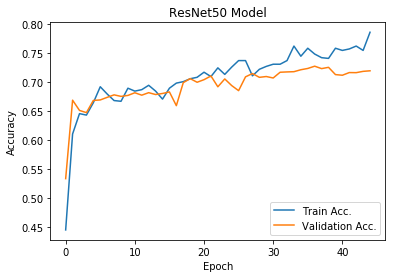

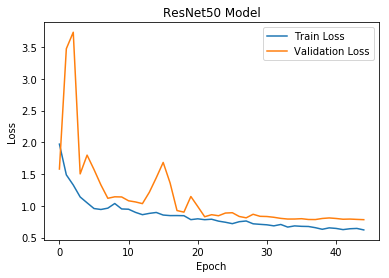

Confusion matrix, without normalization
[[  12   34    5    4   10    0    3]
 [  12   54    8    5   25    4    8]
 [  10   31   63    2   69    2   35]
 [   4   10    0    1    6    3    1]
 [   3   21   15    6 1229   10   58]
 [   0    1    0    0    7   23    0]
 [   8    8   13    1   88    3   88]]


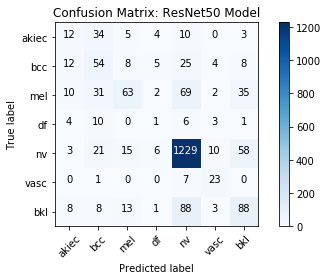

In [2]:
mn.test_resnet50_model(optimizer='Nadam', lr=0.001)

Reading skin cancer data...
Creating ResNet50 Localization Model...
Training model...
Train on 7209 samples, validate on 801 samples
Epoch 1/100
 - 41s - loss: 17.8650 - box_output_loss: 84.2918 - class_output_loss: 1.0067 - box_output_acc: 0.5436 - class_output_acc: 0.6986 - val_loss: 9.0426 - val_box_output_loss: 41.0732 - val_class_output_loss: 0.8279 - val_box_output_acc: 0.6729 - val_class_output_acc: 0.7154

Epoch 00001: val_class_output_acc improved from -inf to 0.71536, saving model to ..\saved_models/resnet50local_valacc0.7154-epoch01.hdf5
Epoch 2/100
 - 28s - loss: 4.1869 - box_output_loss: 18.0418 - class_output_loss: 0.5785 - box_output_acc: 0.7176 - class_output_acc: 0.7962 - val_loss: 6.6432 - val_box_output_loss: 29.1668 - val_class_output_loss: 0.8099 - val_box_output_acc: 0.7228 - val_class_output_acc: 0.7066

Epoch 00002: val_class_output_acc did not improve from 0.71536
Epoch 3/100
 - 28s - loss: 2.7928 - box_output_loss: 12.1059 - class_output_loss: 0.3716 - box_out


Epoch 00022: val_class_output_acc did not improve from 0.79026
Epoch 23/100
 - 29s - loss: 0.1641 - box_output_loss: 0.8116 - class_output_loss: 0.0017 - box_output_acc: 0.9329 - class_output_acc: 0.9996 - val_loss: 3.8404 - val_box_output_loss: 13.3022 - val_class_output_loss: 1.1800 - val_box_output_acc: 0.7965 - val_class_output_acc: 0.7765

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00023: val_class_output_acc did not improve from 0.79026
Epoch 24/100
 - 29s - loss: 0.1425 - box_output_loss: 0.7066 - class_output_loss: 0.0011 - box_output_acc: 0.9362 - class_output_acc: 0.9999 - val_loss: 3.8115 - val_box_output_loss: 13.1183 - val_class_output_loss: 1.1878 - val_box_output_acc: 0.7953 - val_class_output_acc: 0.7753

Epoch 00024: val_class_output_acc did not improve from 0.79026
Epoch 25/100
 - 29s - loss: 0.1318 - box_output_loss: 0.6535 - class_output_loss: 0.0011 - box_output_acc: 0.9376 - class_output_acc: 1.0000 - val_loss: 3.8311 -

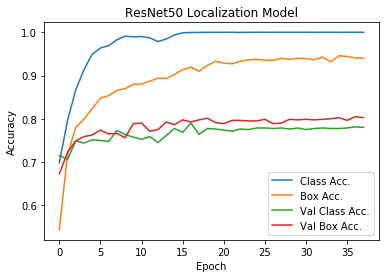

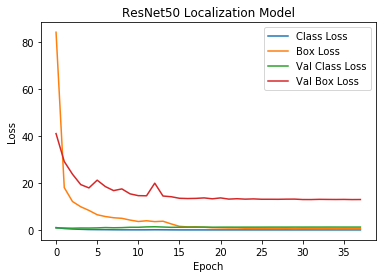

Confusion matrix, without normalization
[[  34   11   10    0    3    9    0]
 [   6   73   12    0    8   11    2]
 [   5   10  119    1   27   52    0]
 [   4    6    1   10    0    4    0]
 [   3    1   26    0   99   76    1]
 [   2    8   26    2   41 1270    2]
 [   0    2    0    0    0    4   22]]


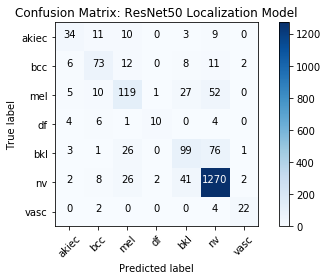

In [3]:
mn.test_resnet50_localization_model(optimizer='adam', lr=0.0001)

### 4c. Custom architecture

We wished to explore architecture depth due to the smaller size of these images - consider that VGG16 was based off of 224x224 images, while we based our models of off 64x64 and a much simpler dataset (only 7 classes). 

Because of this, we should be able to train a much simpler, quicker, model but still achieve comparable accuracies.

We present a 7 convolutional-layer network based on selective truncation of the VGG16 network, with a 64x64 receptive field. The table below outlines the architecture:

| Input (?,64,64,3) |
| ----------------- |
| Conv3-64 (?,62,62,3) |
| 2D ZeroPadding (?,64,64,3) |
| BatchNormalization |
| Conv3-64 (?,62,62,3) }
| 2D ZeroPadding (?,64,64,3) |
| MaxPool-2,2 (?,32,32,3) |
| Conv3-128 (?,30,30,3) |
| Conv3-128 (?,28,28,3) |
| MaxPool-2,2 (?,14,14,3) |
| Conv3-256 (?,12,12,3) |
| MaxPool-2,2 (?,6,6,3) |
| Conv3-512 (?,4,4,3) |
| Conv3-512 (?,2,2,3) |
| MaxPool-2,2 (?,1,1,3) |

The architecture splits for classfication and localization:

| classification | localization |
| -------------- | ------------ |
| Flatten()      | Flatten()    |
| Dense(4096, relu) | Dense(4096, relu) |
| Dense(4096, relu) | Dense(4096, relu) |
| Dense(7, relu)    | Dense(4, relu) | 



Reading skin cancer data...
Creating support objects...
Augmenting dataset...
Creating custom model 1...
Epoch 1/100
7/6 [=================================] - 7s 983ms/step - loss: 4.8303 - acc: 0.6225 - val_loss: 5.3466 - val_acc: 0.6683

Epoch 00001: val_acc improved from -inf to 0.66828, saving model to ..\saved_models/custom1_valacc0.6683-epoch01.h5
Epoch 2/100
7/6 [=================================] - 4s 622ms/step - loss: 5.0089 - acc: 0.6892 - val_loss: 5.3466 - val_acc: 0.6683

Epoch 00002: val_acc did not improve from 0.66828
Epoch 3/100
7/6 [=================================] - 5s 730ms/step - loss: 5.3261 - acc: 0.6696 - val_loss: 5.3466 - val_acc: 0.6683

Epoch 00003: val_acc improved from 0.66828 to 0.66828, saving model to ..\saved_models/custom1_valacc0.6683-epoch03.h5
Epoch 4/100
7/6 [=================================] - 4s 623ms/step - loss: 5.3261 - acc: 0.6696 - val_loss: 5.3466 - val_acc: 0.6683

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00050000002

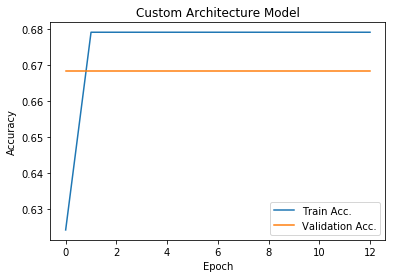

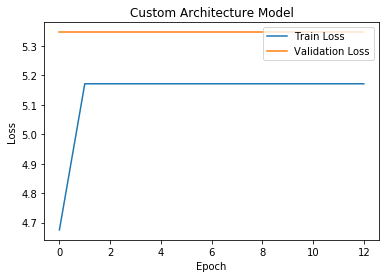

Confusion matrix, without normalization
[[   0    0    0    0   68    0    0]
 [   0    0    0    0  116    0    0]
 [   0    0    0    0  212    0    0]
 [   0    0    0    0   25    0    0]
 [   0    0    0    0 1342    0    0]
 [   0    0    0    0   31    0    0]
 [   0    0    0    0  209    0    0]]


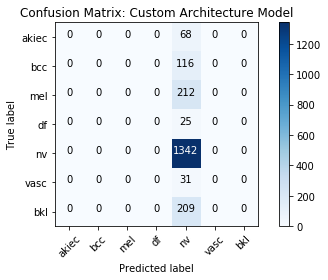

In [5]:
custom_model = mn.test_custom_architecture1_model(optimizer='Nadam', lr=0.001)

above: example of a 'dumb' classifier, that got stuck only predicing Melanocytic nevi.

Reading skin cancer data...
Creating custom architecture Localization Model...
Training model...
Train on 7209 samples, validate on 801 samples
Epoch 1/100
 - 19s - loss: 18.4629 - box_output_loss: 171.0066 - class_output_loss: 1.3622 - box_output_acc: 0.4816 - class_output_acc: 0.6441 - val_loss: 5.3575 - val_box_output_loss: 43.4219 - val_class_output_loss: 1.0153 - val_box_output_acc: 0.5668 - val_class_output_acc: 0.6754

Epoch 00001: val_class_output_acc improved from -inf to 0.67541, saving model to ..\saved_models/custom1_local_valacc0.6754-epoch01.hdf5
Epoch 2/100
 - 14s - loss: 4.6427 - box_output_loss: 36.7840 - class_output_loss: 0.9643 - box_output_acc: 0.6359 - class_output_acc: 0.6778 - val_loss: 4.1714 - val_box_output_loss: 32.5361 - val_class_output_loss: 0.9178 - val_box_output_acc: 0.6929 - val_class_output_acc: 0.6904

Epoch 00002: val_class_output_acc improved from 0.67541 to 0.69039, saving model to ..\saved_models/custom1_local_valacc0.6904-epoch02.hdf5
Epoch 3/1


Epoch 00021: val_class_output_acc improved from 0.73783 to 0.74282, saving model to ..\saved_models/custom1_local_valacc0.7428-epoch21.hdf5
Epoch 22/100
 - 14s - loss: 1.4759 - box_output_loss: 9.2426 - class_output_loss: 0.5517 - box_output_acc: 0.8266 - class_output_acc: 0.7950 - val_loss: 2.0665 - val_box_output_loss: 13.5732 - val_class_output_loss: 0.7092 - val_box_output_acc: 0.8077 - val_class_output_acc: 0.7353

Epoch 00022: val_class_output_acc did not improve from 0.74282
Epoch 23/100
 - 14s - loss: 1.4520 - box_output_loss: 9.1419 - class_output_loss: 0.5378 - box_output_acc: 0.8273 - class_output_acc: 0.8062 - val_loss: 2.0838 - val_box_output_loss: 13.6925 - val_class_output_loss: 0.7145 - val_box_output_acc: 0.8027 - val_class_output_acc: 0.7291

Epoch 00023: val_class_output_acc did not improve from 0.74282
Epoch 24/100
 - 14s - loss: 1.4163 - box_output_loss: 8.8704 - class_output_loss: 0.5292 - box_output_acc: 0.8287 - class_output_acc: 0.8050 - val_loss: 2.2050 - val


Epoch 00043: val_class_output_acc did not improve from 0.75655
Epoch 44/100
 - 14s - loss: 0.9494 - box_output_loss: 5.9207 - class_output_loss: 0.3574 - box_output_acc: 0.8500 - class_output_acc: 0.8789 - val_loss: 2.0132 - val_box_output_loss: 13.1015 - val_class_output_loss: 0.7030 - val_box_output_acc: 0.8115 - val_class_output_acc: 0.7491

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 00044: val_class_output_acc did not improve from 0.75655
Epoch 45/100
 - 14s - loss: 0.9421 - box_output_loss: 5.8599 - class_output_loss: 0.3561 - box_output_acc: 0.8503 - class_output_acc: 0.8821 - val_loss: 2.0117 - val_box_output_loss: 13.0818 - val_class_output_loss: 0.7035 - val_box_output_acc: 0.8065 - val_class_output_acc: 0.7453

Epoch 00045: val_class_output_acc did not improve from 0.75655


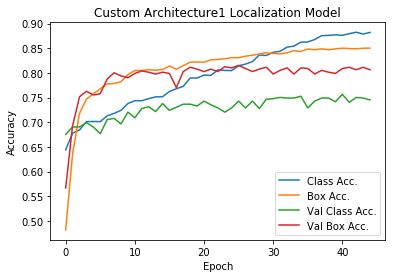

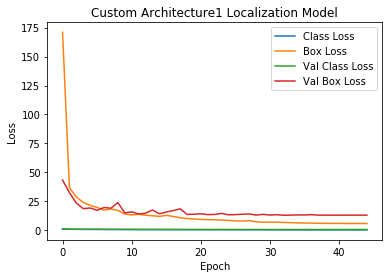

Confusion matrix, without normalization
[[  20   15   14    0    6   12    0]
 [  13   58   14    0    5   18    4]
 [   6    9   95    0   27   76    1]
 [   7    7    4    0    0    7    0]
 [   4    3   21    0   85   91    2]
 [   8    8   30    2   44 1253    6]
 [   0    1    1    0    1    6   19]]


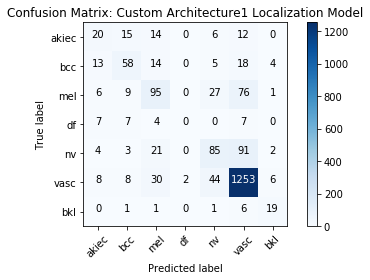

In [5]:
custom_localization = mn.test_custom_architecture1_localization_model(optimizer='adam', lr=0.0001)

## Conclusion
See report pdf for discussions on this notebook.